## Биометрия и нейротехнологии. Лабораторная работа №4

#### UPD: v.2: изменения, начиная со слов: UPDATE 04.06.2020:
    * Переделано преобрахование Фурье
    * Соответственно, далее результаты вычислений тоже изменились.

<div style="text-align: right"> 
    Чангалиди Антон, P3214
<br>
   Исследование периодических составляющих вариабельности сердечного ритма
</div>

## Репозиторий:

https://github.com/TohaRhymes/biometrics_itmo_spring_2020/tree/master/lab4_heart_variability

## Поехали!

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt

Прочитаем данные и посмотрим на них

In [2]:
data = pd.read_csv('../lab3_pandas_heart_variability/part2_biometry/4_f_1.csv', names = ['RR'])
RR = data.RR
RR

0      866
1      927
2      924
3      892
4      897
      ... 
295    842
296    829
297    806
298    883
299    882
Name: RR, Length: 300, dtype: int64

**1. По заданному массиву кардиоинтервалов построить кардиоритмограмму, представляющую собой зависимость длительности кардиоинтервалов от времени.** 

Для этого по оси ординат Y откладываются значения кардиоинтервалов, по оси абсцисс Х откладывается текущее время, которое получается путем суммирования значений кардиоинтервалов.

300


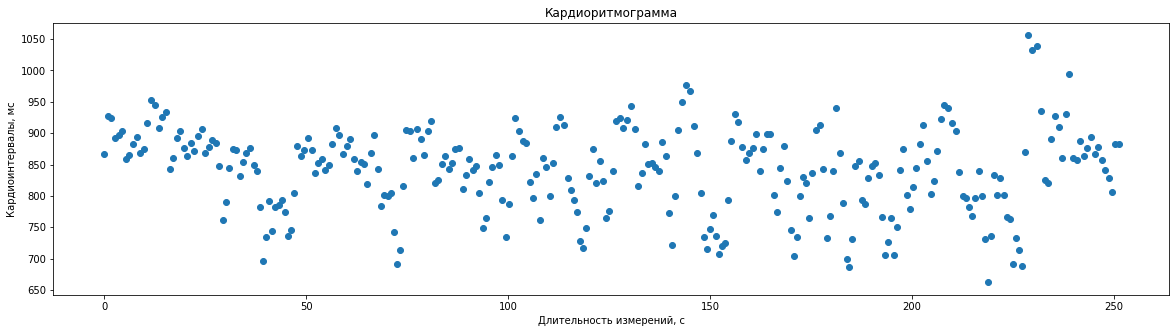

In [3]:
# time_step = 1
# time_vec = np.arange(0, 300, time_step)
signal = np.array(RR)
print(len(signal))
time_x = [0]
for i in range(0,len(signal)-1):
    time_x.append(signal[i]/1000+time_x[i])
plt.figure(figsize=(20, 5))
plt.plot(time_x, signal, 'o')
plt.title('Кардиоритмограмма')
plt.ylabel('Кардиоинтервалы, мс')
plt.xlabel('Длительность измерений, с')
plt.show()

**2. Переход к новому ряду.**

Полученная последовательность значений длительностей КИ представляет собой временную функцию с нерегулярными отсчетами. Для корректного преобразования Фурье требуется перейти к новому ряду дискретных значений $x_i , i = 1, 2, ..., N$. Для этого дискретные значения КИ, последовательно отложенные по оси абсцисс, принимаются за опорные точки, Затем проводится аппроксимация отсчетов с помощью гладких функций. Для реализации данного шага наиболее часто применяют интерполяцию с помощью полиномов или сплайнов разной степени. Заключительным этапом является переоцифровка полученной кривой с постоянным шагом по времени (предлагается $\Delta t = 250$).

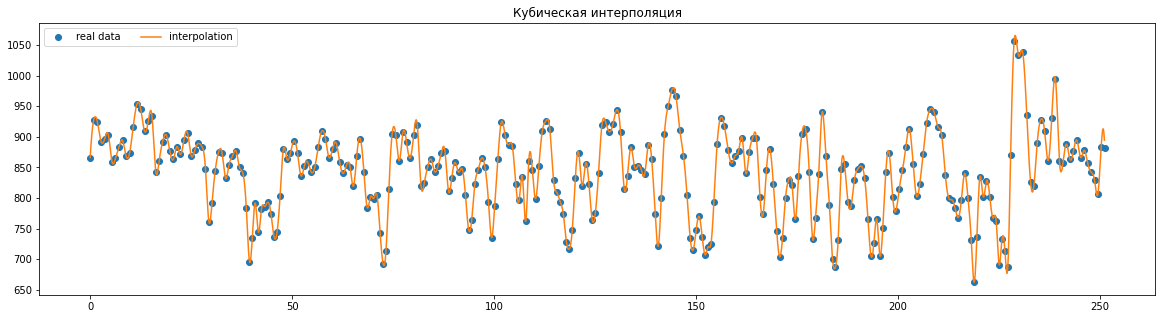

In [4]:
from scipy.interpolate import CubicSpline
cs = CubicSpline(time_x, signal)
xs = np.arange(0, max(time_x), 0.1)
# time = np.array([i * max(time_x)/len(time_x) for i in range(len(time_x))])
plt.figure(figsize=(20, 5))
plt.title('Кубическая интерполяция')
plt.plot(time_x, signal, 'o', label='real data')
plt.plot(xs, cs(xs), label="interpolation")
plt.legend(ncol=2)
plt.show()

Создаем новые значения:

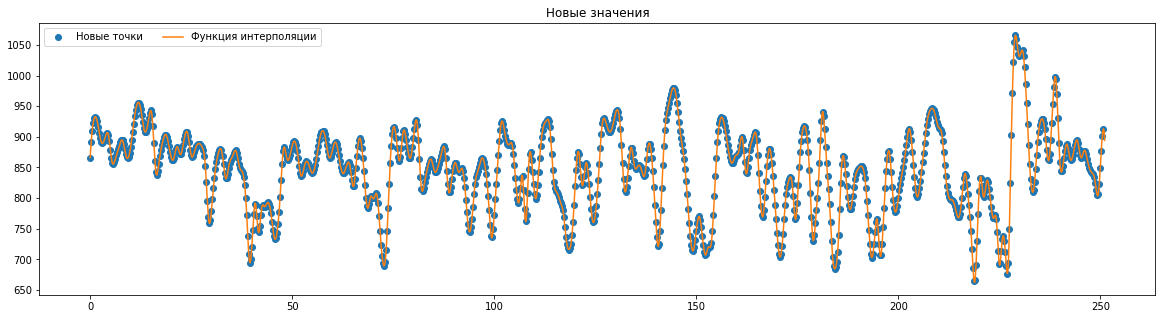

In [5]:
max_time = int(max(time_x))
delta = 0.25
scale = 1/delta
n_batch = int(max_time*scale/2)
time = np.array([float(i)*delta for i in range(int(n_batch*2))])
values = cs(time)
plt.figure(figsize=(20, 5))
plt.title('Новые значения')
plt.plot(time, values, 'o', label="Новые точки")
plt.plot(xs, cs(xs), label="Функция интерполяции")
plt.legend(ncol=2)
plt.show()

**3. Преобразование Фурье**

Осуществить преобразование Фурье дискретного ряда значений $x_i , i = 1, 2, ..., N$, полученных на предыдущем этапе.

/home/toharhymes/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


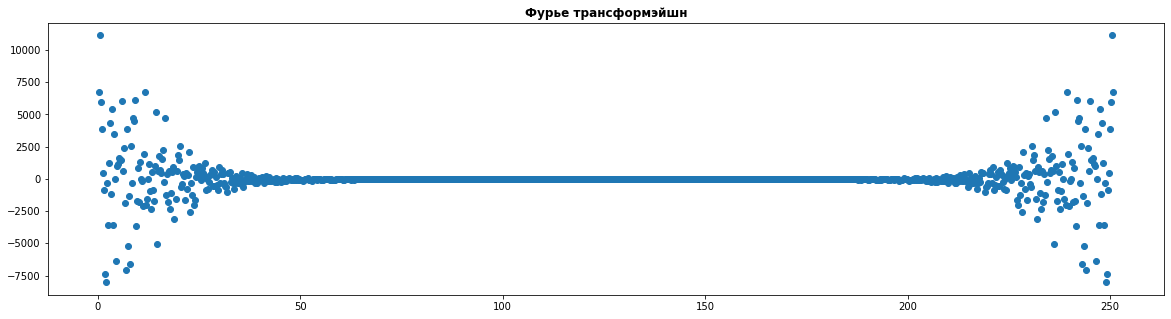

In [6]:
from scipy.fft import fft


sample_fourier = fft(values, n=2*n_batch)
plt.figure(figsize=(20, 5))
plt.title("Фурье трансформэйшн", fontweight="bold")
plt.plot(time[1:], sample_fourier[1:], 'o')
plt.show()


По каким-то причинам, оно дает странные результаты.
#### UPDATE 04.06.2020
Полазив в интернете, и поняв ключевую проблему библиотечных реализаций преобразования Фурье (спасибо Дмитрию Геннадьевичу): она действенна только для равномерных распределений, я нашел хороший [выход](https://www.reddit.com/r/Python/comments/dk85ue/easy_fourier_transform_implementing_3blue1browns/?utm_source=share&utm_medium=web2x).
Воспользуюсь приведенным кодом:

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

In [8]:
# from here https://stackoverflow.com/a/16445006/4999991
def polarToRectangular(radii, angles):
    return radii * np.exp(1j * angles)

def sortZip(x, y):
    order = np.argsort(x)
    xs = np.array(x)[order]
    ys = np.array(y)[order]
    return xs, ys

def plotSort(x, y):
    xs, ys = sortZip(x, y)
    plt.plot(xs, ys)
    
def frequencyGenerator(time, steps=None):
    𝛿 = time.max() - time.min()
    if steps is None:
        steps = int(𝛿 / np.diff(time).mean() / 2) # or np.diff(time).min()
    M = np.arange(1, steps + 1)
    return M / 𝛿, steps

def easyFourierTransform(time, signal, frequency=None, steps=None, sorted=False, uniform=False):
    if sorted:
        ts = time
        Xs = signal
    else:
        ts, Xs = sortZip(time, signal)
    
    if frequency is None:
        frequency, steps = frequencyGenerator(ts, steps)
    else:
        steps = frequency.shape[0]
#     print(frequency)
    
    if uniform:
        N = signal.shape[0]
        amplitude = np.abs(scipy.fftpack.fft(signal)[:steps]) * 2.0 / N
    else:
        ft = frequency[:, np.newaxis]
        𝜃 = (ts - ts.min()) * 2 * np.pi * ft
        Y = polarToRectangular(Xs, 𝜃)[:, 1:] * np.diff(ts)
        amplitude = np.abs(Y.sum(axis=1))
    return frequency, amplitude

##### Ну и воспользуемся новым преобразованием Фурье

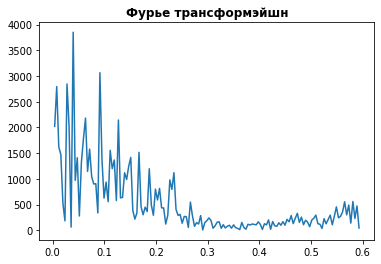

In [9]:
freq, sample_fourier = easyFourierTransform(time_x, signal)
plt.plot(freq, sample_fourier)
plt.title("Фурье трансформэйшн", fontweight="bold")
n_batch=len(freq)

**3. Спектральная мощность полученного сигнала**

* Рассчитать **спектральную мощность полученного сигнала**
* Построить **график зависимости спектральной плотности мощности временной последовательности длительностей кардиоинтервалов от частоты/времени**.





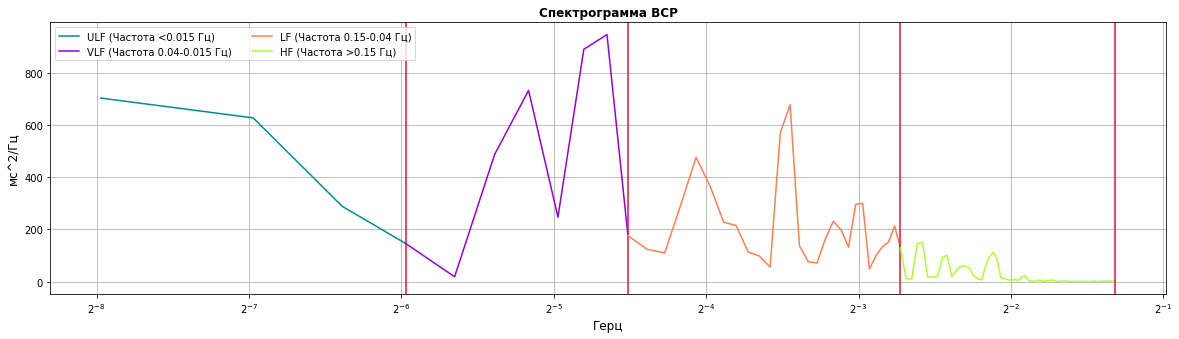

In [10]:
##Не забудем нормировать умножением на sqrt(2)
sample_fourier *= math.sqrt(2)


labels = ['HF', 'LF', 'VLF', 'ULF']
borders_freq = [float('+inf'), 0.4, 0.15, 0.04, 0.015, 0]
borders_times = [2.5, 25, 66]

# Посчитаем мощность
final_values = np.array(abs(np.power(sample_fourier, 2)/(n_batch**2)))
final_values = [val.real for val in final_values]
# final_values = final_values[n_batch:2*n_batch]
final_values = final_values[0*n_batch:1*n_batch]
final_values[0] = final_values[1]

# линейное усреднение Pl по сегментам.
# усредню по соседям (если не так, то несложно переделать)
final_values[1:n_batch-1] = np.add(final_values[1:n_batch-1],final_values[1:n_batch-1])
final_values[1:n_batch-1] = np.add(final_values[1:n_batch-1],final_values[2:n_batch])
final_values[1:n_batch-1]/=np.ones(len(final_values)-2)*3


# I used this for old version of interpolation
# But I left it for emergencies


# herz = np.ones(n_batch)/(np.ones(n_batch)*time[n_batch] - time[:n_batch])
# part = 0
# final_time = [[]]
# final_vals = [[]]
# for h, t, v in zip(herz[::-1], time[:n_batch], final_values):
#     if h < borders_freq[part+1]:
#         part+=1
#         final_time.append([])
#         final_vals.append([])
#     final_time[part].append(t)
#     final_vals[part].append(v)

# plt.figure(figsize=(20, 5))
# colors = ['darkcyan','darkviolet','coral','greenyellow']
# labels = ['ULF (Частота <0.015 Гц)', 'VLF (Частота 0.04-0.015 Гц)', 'LF (Частота 0.15-0.04 Гц)', 'HF (Частота >0.15 Гц)']
# for val, t, col, lab in zip(final_vals, final_time, colors, labels):
#     plt.plot(t, val, color = col, label = lab)
#     plt.axvline(x=t[-1], color = 'crimson')
# plt.grid()
# x_label = plt.xlabel('c', fontsize=12)
# y_label = plt.ylabel('мс^2/Гц', fontsize=12)
# title = plt.title('Спектрограмма ВСР', fontweight="bold")
# # plt.xscale(value='log', basex=2)
# plt.legend(ncol=2)
# plt.show()

# Now we can use this (since we got ready frequencies in freq)

labels = labels[::-1]
borders_freq = borders_freq[::-1]

part = 0
final_vals = [[]]
final_freq = [[]]
for h, v in zip(freq, final_values):
#     print(h)
    if h > borders_freq[part+1]:
        final_freq[part].append(h)
        final_vals[part].append(v)
        part+=1
        final_freq.append([])
        final_vals.append([])
    final_freq[part].append(h)
    final_vals[part].append(v)

plt.figure(figsize=(20, 5))
colors = ['darkcyan','darkviolet','coral','greenyellow']
labels = ['ULF (Частота <0.015 Гц)', 'VLF (Частота 0.04-0.015 Гц)', 'LF (Частота 0.15-0.04 Гц)', 'HF (Частота >0.15 Гц)']
for val, h, col, lab in zip(final_vals, final_freq, colors, labels):
    plt.plot(h, val, color = col, label = lab)
    plt.axvline(x=h[-1], color = 'crimson')
plt.grid()
x_label = plt.xlabel('Герц', fontsize=12)
y_label = plt.ylabel('мс^2/Гц', fontsize=12)
title = plt.title('Спектрограмма ВСР', fontweight="bold")
plt.xscale(value='log', basex=2)
plt.legend(ncol=2)
plt.show()




**4.  Мощности спектров в диапазонах**

* В соответствии с таблицей (см. ниже) рассчитать мощности спектров в каждом из указанных диапазоне частот, указать их минимальное и максимальное значения. 
* Рассчитать суммарную мощность спектра ВСР и мощности спектра в каждом частотном диапазоне в процентном отношении ко всему диапозону.
![](table1.png)

In [11]:
f_max = []
f_min = []
power = []
for l in final_vals:
    f_max.append(max(l))
    f_min.append(min(l))
    power.append(sum(l))
total = sum(power)
print(f'Суммарная мощность спектра ВСР = {total}')
for mx, mn, pw, lab in zip(f_max, f_min, power, labels):
    print(f'В диапазоне {lab}:\n\t* Максимальное значение плотности мощности = {mx}'+
            f'\n\t* Минимальное значение плотности мощности = {mn}'+
            f'\n\t* Мощность = {pw}, что составляет {pw/total*100}% общей мощности')

Суммарная мощность спектра ВСР = 13149.60471668401
В диапазоне ULF (Частота <0.015 Гц):
	* Максимальное значение плотности мощности = 703.5264566402382
	* Минимальное значение плотности мощности = 146.57681246304617
	* Мощность = 1766.2049225528667, что составляет 13.431619889774588% общей мощности
В диапазоне VLF (Частота 0.04-0.015 Гц):
	* Максимальное значение плотности мощности = 946.9462279450084
	* Минимальное значение плотности мощности = 18.739262845984058
	* Мощность = 3647.1859487377, что составляет 27.73608809784379% общей мощности
В диапазоне LF (Частота 0.15-0.04 Гц):
	* Максимальное значение плотности мощности = 677.658201685554
	* Минимальное значение плотности мощности = 48.59369531984578
	* Мощность = 5893.376885444379, что составляет 44.81790146868031% общей мощности
В диапазоне HF (Частота >0.15 Гц):
	* Максимальное значение плотности мощности = 150.96665171240411
	* Минимальное значение плотности мощности = 0.09413576489112951
	* Мощность = 1491.9593108888737, что с

**4. Расчет индексов**

По полученным данным рассчитать индекс централизации ИЦ (IC), индекс вагосимпатического взаимодействия ИВВ и индекс активации подкорковых нервных центров ИАП (ISCA).



In [12]:
n_to_i = {'HF':0, 'LF':1, 'VLF':2, 'ULF':3}
IC = (power[n_to_i['VLF']] + power[n_to_i['LF']])/power[n_to_i['HF']]
IVV = (power[n_to_i['LF']])/power[n_to_i['HF']]
ISCA = (power[n_to_i['LF']])/power[n_to_i['VLF']]
print('Индексы:')
print(f'\t* индекс централизации ИЦ (IC): {IC}\n'+
      f'\t* индекс вагосимпатического взаимодействия ИВВ: {IVV}\n'+
      f'\t* индекс активации подкорковых нервных центров ИАП (ISCA): {ISCA}')

Индексы:
	* индекс централизации ИЦ (IC): 5.401730406453733
	* индекс вагосимпатического взаимодействия ИВВ: 2.064984590500444
	* индекс активации подкорковых нервных центров ИАП (ISCA): 0.6188618205880602


**5. Анализ полученных данных**

Проанализировать полученные данные.

Показатель **HF** - отвечает за парасимпатическое звено регуляции (способствует восстановлению израсходованных запасов энергии, регулирует работу организма во время сна). Относительно других (да и по абсолютному значению), оно невелико (11.3% общей мощности). Значение плотности мощности лежат в интервале \[0.009;150.9\] $msec^2/Hz$ .

Показатель **LF** - отвечает за вазомоторный центр (контроль кровообращения) - около 44.8% от общей мощности - почти половина общей мощности. Значение плотности мощности лежат в интервале \[48.6;677.7\] $msec^2/Hz$

Показатель **VLF** - отвечает за уровень активности симпатического звена регуляции (усиливает обмен веществ, повышает возбуждаемость большинства тканей, мобилизует силы организма на активную деятельность). Мощность = 27.7% от общей - вторая по мощности, наверное, логично, что они с LF самые мощные, так как контролировать кровообращение, и вообще обмен веществ - очень важно.  Значение плотности мощности лежат в интервале \[18.7;947\] $msec^2/Hz$

Показатель **ULF** - отвечает за уровень уровень активности субкортикальных уровней регуляции (высших вегетативных (автономных) центров). Мощность - 13.4% общей мощности, как и **HF** - невелико относительно других. Значение плотности мощности лежат в интервале \[146.6;703.5\] $msec^2/Hz$

**Индекс централизации** отражает степень централизации управления ритмом сердца (преобладания активности центрального контура регуляции над автономным, т.е. преобладание недыхательных составляющих синусовой аритмии над дыхательными). В нашем случае он равен $5.4$.

**Индекс активации подкорковых нервных центров ИАП** характеризует активность сердечно-сосудистого подкоркового нервного центра по отношению к более высоким уровням управления. Увеличение ИАП свидетельствует о повышенной активности подкорковых нервных центров. В нашем случае он равен $0.6$.